# Simple Neural Network
## Day 2 - Clean Network

In this section, we haved used codes from privous section and cleaned it up to get a dynamic code that could handle more vriaity of architechtures.

In [1]:
import os
import numpy as np
from random import randint
import matplotlib.pyplot as plt

First we would need some modifier functions to work with the image. Thus, here we define some of them:

In [2]:
def flatten(input_value):
    return input_value.reshape(input_value.shape[0], -1)

def normalize(input_value):
    res = input_value - np.min(input_value)
    return res / np.max(res)

def image_preprocess(image_data):
    return normalize(flatten(image_data))

Afterward, we required a better approch toward the activation function and their derivative. So, here we define an abstract class to handle the complexity of this functions.

In [3]:
from abc import abstractmethod

# TODO: fix abstraction
class ActivationFunction:    
    @abstractmethod
    def activate(self, x):
        pass

    @abstractmethod
    def derivative(self, x):
        pass
    
    def __call__(self, x):
        return self.activate(x)

    
# And here some sample activation functions
class Sigmoid(ActivationFunction):
    def activate(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def derivative(self, x):
        return self.activate(x) * (1.0 - self.activate(x)) 

class ReLU(ActivationFunction):
    def activate(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return 1.0 * (x > 0)
    

class tanh(ActivationFunction):
    def activate(self, x):
        return np.tanh(x)

    def derivative(self, x):
        return 1.0 / np.cosh(x) ** 2


ACTIVATION_FUNCTIONS = {
    'sigmoid': Sigmoid(),
    'relu': ReLU(),
    'tanh': tanh(),
}

def get_activation_function(actv_func):
    if isinstance(actv_func, str):
        if actv_func not in ACTIVATION_FUNCTIONS:
            raise Exception('activation "%s" not found' % actv_func)
        actv_func = ACTIVATION_FUNCTIONS[actv_func]
    return actv_func

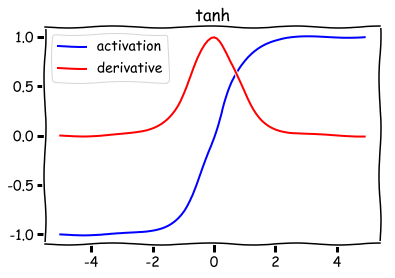

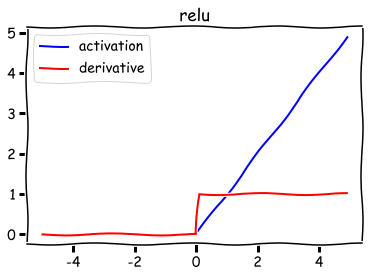

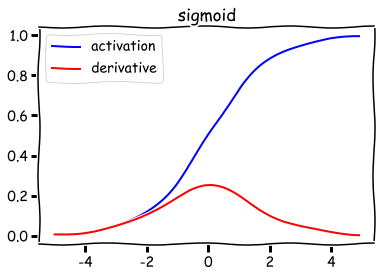

In [4]:
%matplotlib inline

# List Activation Functions
with plt.xkcd():
    x = np.array(list(range(-50, +50))) / 10.0
    for name, func in ACTIVATION_FUNCTIONS.items():
        plt.plot(x, func(x), 'b', label='activation')
        plt.plot(x, func.derivative(x), 'r', label='derivative')
        plt.title(name)
        plt.legend()
        plt.show()

We have defined a `Layer` class which represent each layers of the network. Each layer is defined by a `n` representing its number of neurons and a `actv_func` (short for activation-function). Then each layer has three functionality, either they can perform a forward propagation, a backward propagation, or they can optimize theyr weights.

In [5]:
class Layer:
    def __init__(self, n, prev_n, actv_func):
        self.actv_func = get_activation_function(actv_func)
        self.n = n
        self.prev_n = prev_n
        self.initialize()
        
    def initialize(self):
        self.w = np.random.uniform(low=0, high=+1, size=(self.n, self.prev_n))
        self.b = np.random.uniform(low=0, high=+1, size=(self.n, 1))

        # These parameters will be used in backprop
        self.x0 = 0
        self.z0 = 0
        self.dw = 0
        self.db = 0
        
        # Debug plot
        self.hist_w = []
        self.hist_b = []
    
    def set_params(self, new_w, new_b, new_func=None):
        if new_w.shape != self.w.shape:
            raise Exception('weight size mismatch. Expecting %s but got %s' % (self.w.shape, new_w.shape))
        if new_b.shape != self.b.shape:
            raise Exception('bias size mismatch. Expecting %s but got %s' % (self.b.shape, new_b.shape))
            
        self.w = new_w
        self.b = new_b
        if new_func is not None:
            self.actv_func = get_activation_function(new_func)
    
    def forward(self, x):
        z = self.w.dot(x) + self.b
        a = self.actv_func(z)
        
        self.z0 = z
        self.x0 = x
        
        return a
    
    def backward(self, error, m):
        delta = error * self.actv_func.derivative(self.z0)
        self.dw = delta.dot(self.x0.T) / float(m)
        self.db = delta.dot(np.ones((m,1))) / float(m)
        return self.w.T.dot(delta)
    
    def optimize_weights(self, eta):
        self.w += eta * self.dw
        self.b += eta * self.db
        
        self.hist_w.append(self.w.flatten())
        self.hist_b.append(self.b.flatten())
        

Afterward, we have defended a class called `network`. This class is responsible for connecting the layers together both in forward and backward propagations.

In [6]:
class Network:
    def __init__(self, input_size):
        self.layers = []
        self.last_layer_size = input_size
        self.lr = 0.01
        self.initialize()
    
    def add_layer(self, n, activation='sigmoid'):
        self.layers.append(Layer(
            n,
            self.last_layer_size,
            activation
        ))
        self.last_layer_size = n
    
    def predict(self, x0):
        z = x0
        for l in self.layers:
            z = l.forward(z)
        return z
    
    def backpropagate(self, x0, y0):
        m = x0.shape[1]
        y_hat = self.predict(x0)
        error = y0-y_hat

        for i in reversed(range(len(self.layers))):
            error = self.layers[i].backward(error, m)
        
        for i in range(len(self.layers)):
            self.layers[i].optimize_weights(self.lr)

    def initialize(self):
        self.loss_history = []
        for l in self.layers:
            l.initialize()
        
    def train(self, x, y, batch_size, epochs, lr=None, initialize=False):
        if initialize:
            self.initialize()
        
        if lr is not None:
            self.lr = lr
        
        for e in range(epochs): 
            i=0
            batch_loss = []
            while(i<x.shape[1]):
                x_batch = x[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]
                i += batch_size
                
                self.backpropagate(x_batch, y_batch)
                batch_loss.append(np.linalg.norm(self.predict(x_batch) - y_batch))

            self.loss_history.append(np.mean(batch_loss))
            
    def plot_loss(self, weight_history=False):
        with plt.xkcd():
            plt.plot(nn.loss_history)
            plt.title('loss')
            plt.show()

            for i, l in enumerate(self.layers):
                plt.plot(l.hist_w)
                plt.title('W%d' % (i+1))
                plt.show()

                plt.plot(l.hist_b)
                plt.title('B%d' % (i+1))
                plt.show()

Before attempting to creating and training the network, we first needs some data.

In [7]:
# creating the dataset
def xor(x, y):
    return 1 if x+y != 1 else 0

x_train_aug = []
y_train_aug = []

for _ in range(1024):
    a = randint(0, 1)
    b = randint(0, 1)
    x_train_aug.append([a, b])
    y_train_aug.append([xor(a, b)])

x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

x_train = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])

y_train = np.array([xor(i[0], i[1]) for i in x_train])

In [8]:
def plot_prediction():
    M = x_train_aug.shape[0]
    xx = x_train_aug[:, 0] + x_train_aug[:, 1] * 2
    xx = np.reshape(xx, (M, 1)).transpose()

    y_hat = nn.predict(x_train_aug.T)

    with plt.xkcd():
        plt.plot(xx.T, y_train_aug, '*', label='truth')
        plt.plot(xx.T, y_hat.T, 'ro', label='predicted')
        plt.legend()
        plt.show()

    for x_i, y_i in zip(x_train, y_train):
        a = nn.predict(np.reshape(x_i, (2, 1)))
        r = 1 * (a > 0.5)
        print x_i, '~~>', '%d (=%.2f)' % (r, a), '[%d]' % y_i

Here is definition of a simple neural network that used in the previous section followed by training it. This network has two layer ,hidden and output, with neuron size of 2 and 1 respectivly.

In [9]:
nn = Network(input_size=2)
nn.add_layer(2)
nn.add_layer(1)

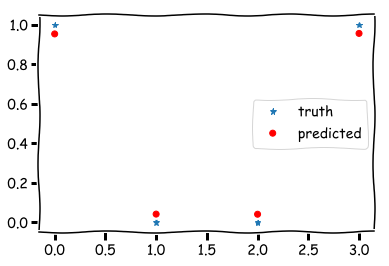

[0 0] ~~> 1 (=0.95) [1]
[0 1] ~~> 0 (=0.04) [0]
[1 0] ~~> 0 (=0.04) [0]
[1 1] ~~> 1 (=0.96) [1]


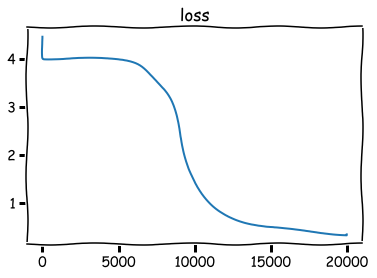

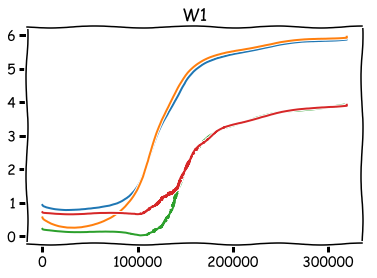

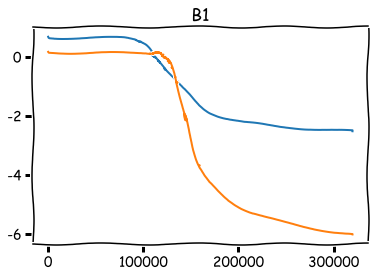

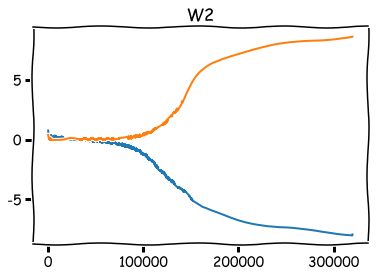

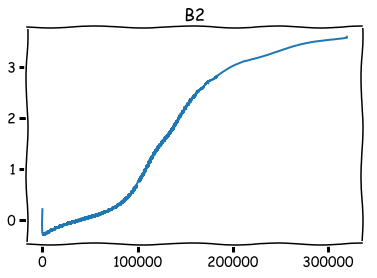

In [10]:
nn.train(x_train_aug.T, y_train_aug.T, epochs=20000, batch_size=64, lr=.02)
plot_prediction()
nn.plot_loss(weight_history=True)

--------------------------------------

In the next section we will run this code on more advance datasets and try to classify images. Please follow up with this [link](https://github.com/ArefMq/simple-nn/blob/master/Day-3.ipynb).